# GDAL

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[GDAL (Geospatial Data Abstraction Library)](http://www.gdal.org/index.html) possui um módulo Python:

In [2]:
import gdal

Podemos utilizá-lo para manipular arquivos GeoTIFF:

In [3]:
bahia_data = gdal.Open('data/2010-07-03T142001_RE4_3A-NAC_6683686_113276.tif')

## Informações do dataset

In [4]:
bahia_data.GetMetadata()

{'AREA_OR_POINT': 'Area',
 'DATE_OF_CREATION': '06_54 29-Jun-11',
 'DATE_OF_UPDATE': '06_54 29-Jun-11',
 'FILE_ID': 'IMG_0000-000-374-194__imagery.pix',
 'GENERATING_FACILITY': 'RapidEye AG',
 'SOFTWARE': 'DPS 8.1'}

In [5]:
bahia_data.GetDriver().ShortName

'GTiff'

In [6]:
bahia_data.GetDriver().LongName

'GeoTIFF'

In [7]:
print bahia_data.RasterXSize
print bahia_data.RasterYSize
print bahia_data.RasterCount

5000
5000
5


In [8]:
bahia_data.GetProjection()

'PROJCS["WGS 84 / UTM zone 23S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32723"]]'

In [9]:
geotransform = bahia_data.GetGeoTransform()
print 'Origin', (geotransform[0], geotransform[3])
print 'Pixel Size', (geotransform[1], geotransform[5])

Origin (403500.0, 8656500.0)
Pixel Size (5.0, -5.0)


## Dados como um array NumPy

In [10]:
B = bahia_data.ReadAsArray()

In [71]:
B.shape

(5, 5000, 5000)

Da documentação do RapidEye, sabemos o significado das 5 bandas:

In [12]:
band_name = {0:'Blue', 1:'Green', 2:'Red', 3:'Red Edge', 4:'Near-Infrared'}

E seus comprimentods de onda:

In [14]:
band_range = {0:(440,510), 1:(520,590), 2:(630,685), 3:(690,730), 4:(760,850)}

In [15]:
bands = range(5)
for b in bands:
    print 'Banda %d, %s, %s' % (b, band_name[b], band_range[b])

Banda 0, Blue, (440, 510)
Banda 1, Green, (520, 590)
Banda 2, Red, (630, 685)
Banda 3, Red Edge, (690, 730)
Banda 4, Near-Infrared, (760, 850)


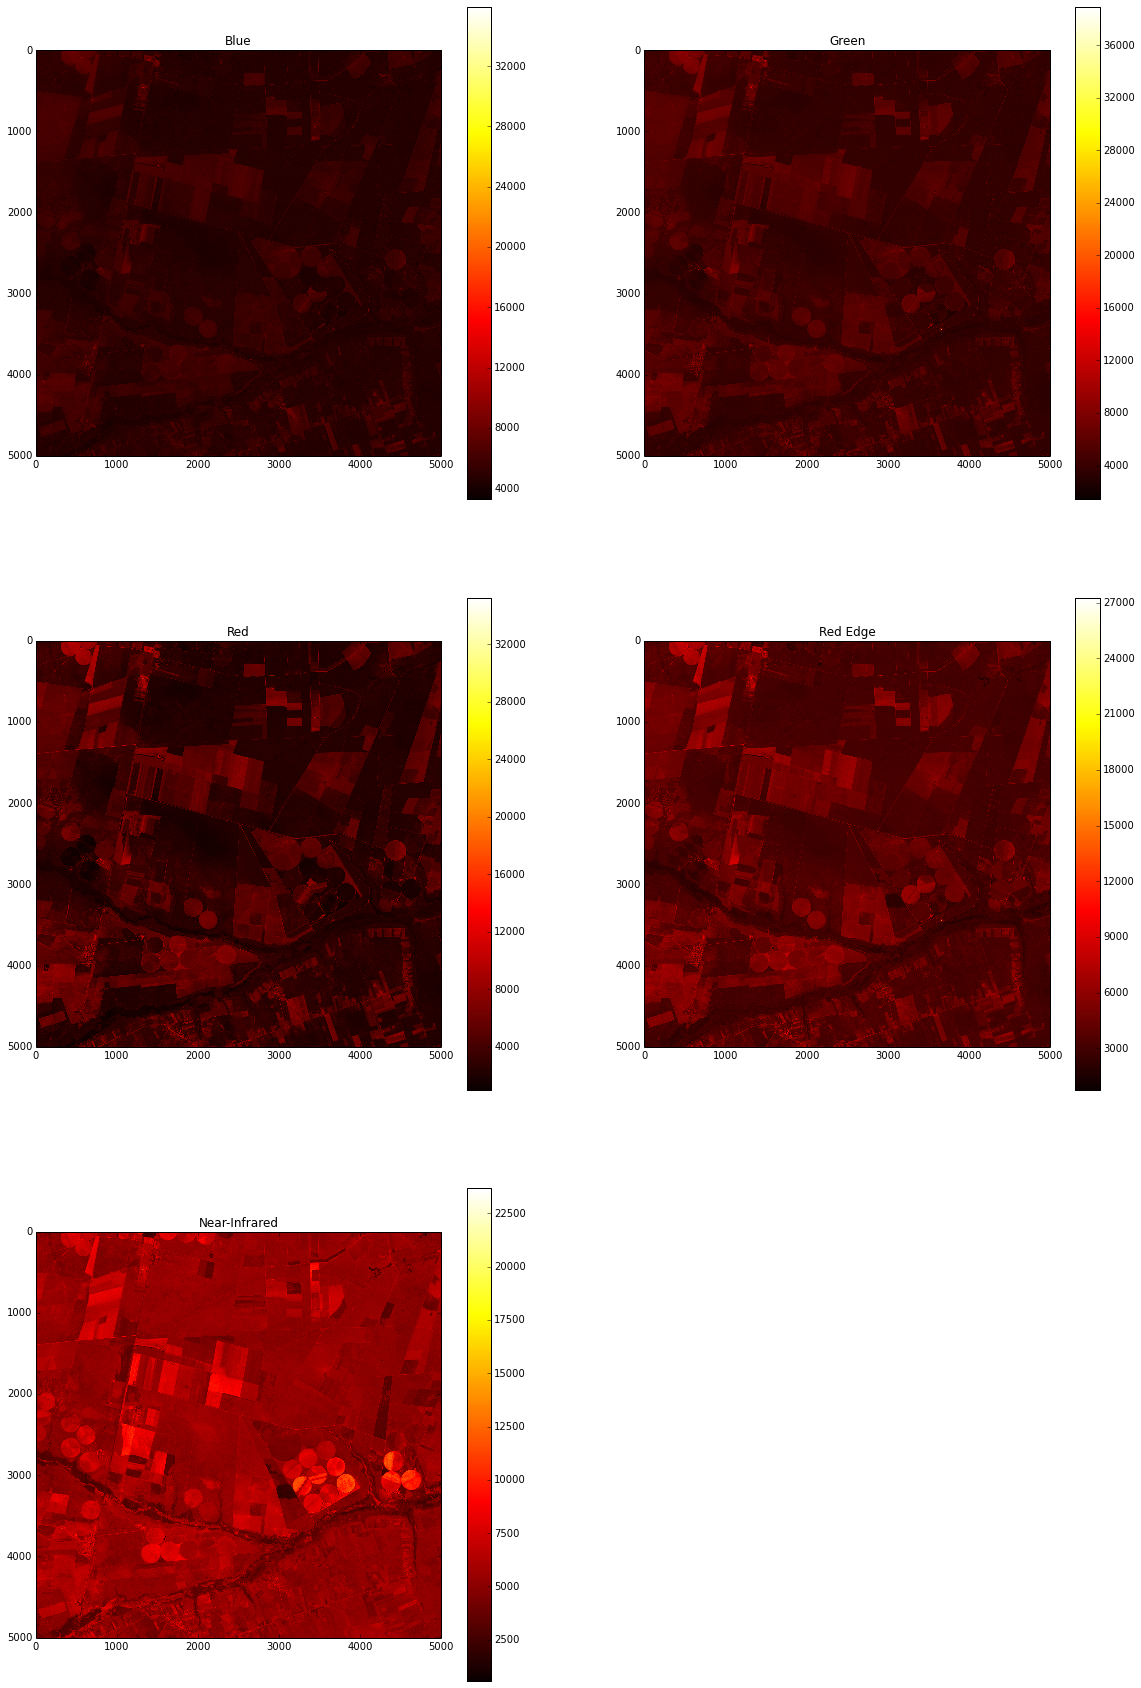

In [16]:
figsize(20,30)
for b in bands:
    subplot(3,2,b+1)
    imshow(B[b], interpolation='nearest', cmap=cm.hot)
    colorbar()
    title(band_name[b])

* Matrizes correspondentes a imagens de alta resolução podem ocupar muita memória
* Convém acompanhar o tamanho das matrizes em memória com o comando "mágico" `%whos`
* Matrizes que não estão em uso podem ser eliminadas com o comando `del`

In [19]:
C = B.copy()

In [20]:
%whos

Variable       Type       Data/Info
-----------------------------------
B              ndarray    5x5000x5000: 125000000 elems, type `uint16`, 250000000 bytes (238 Mb)
C              ndarray    5x5000x5000: 125000000 elems, type `uint16`, 250000000 bytes (238 Mb)
b              int        4
bahia_data     Dataset    <osgeo.gdal.Dataset; prox<...>w *' at 0x7f471c3debd0> >
band_name      dict       n=5
band_range     dict       n=5
bands          list       n=5
dict           dict       n=6
gdal           module     <module 'gdal' from '/usr<...>/dist-packages/gdal.pyc'>
geotransform   tuple      n=6


In [22]:
del(C)
%whos

Variable       Type       Data/Info
-----------------------------------
B              ndarray    5x5000x5000: 125000000 elems, type `uint16`, 250000000 bytes (238 Mb)
b              int        4
bahia_data     Dataset    <osgeo.gdal.Dataset; prox<...>w *' at 0x7f471c3debd0> >
band_name      dict       n=5
band_range     dict       n=5
bands          list       n=5
dict           dict       n=6
gdal           module     <module 'gdal' from '/usr<...>/dist-packages/gdal.pyc'>
geotransform   tuple      n=6


# PCA

Vamos reduzir a dimensionalidade dos dados com PCA (*Principal Components Analysis*):

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=1)

Vamos representar nossos $5000 \times 5000$ pixels como 25 milhões de pontos com 5 dimensões (as 5 bandas)

Primeiro, vamos usar `dstack` para "empilhar" as 5 bandas em uma imagem de $5000 \times 5000 \times 5$:

In [26]:
X = dstack([B[b] for b in bands])
X.shape

(5000, 5000, 5)

Agora vamos redimensionar nossos dados $\mathtt{X}$ para $N$ elementos com 5 dimensões. 

$N = 5.000 \cdot 5.000 = 25.000.000$

In [27]:
X = X.reshape(5000**2, -1)
X.shape

(25000000, 5)

PCA *fitting*:

In [29]:
pca.fit(X)

PCA(copy=True, n_components=1, whiten=False)

Transformação:

In [30]:
Y = pca.transform(X)
Y.shape

(25000000, 1)

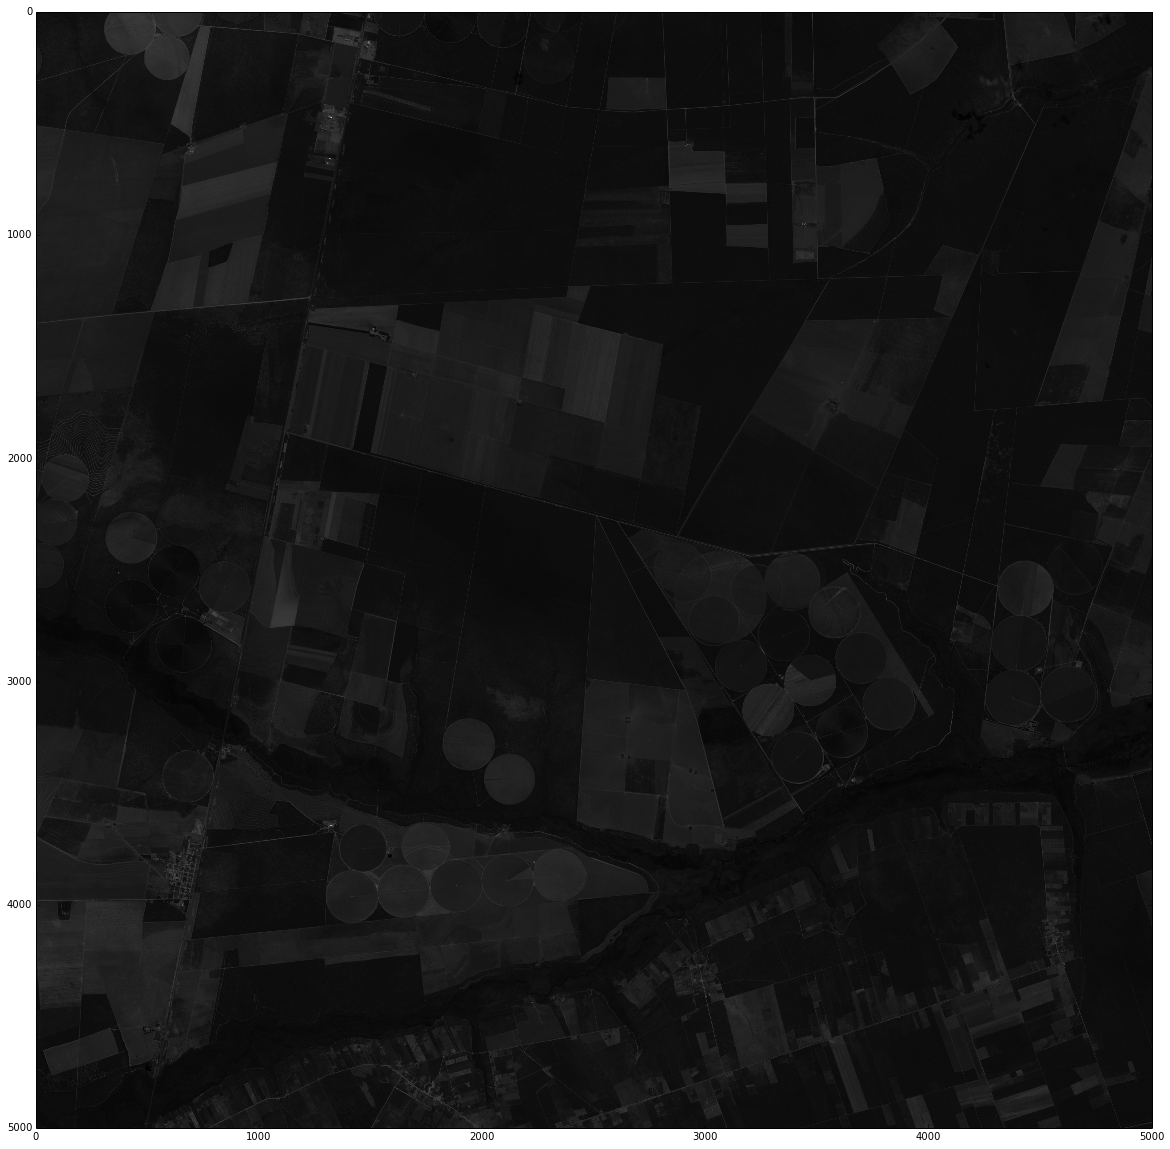

In [31]:
Y = Y.reshape(5000, 5000)
imshow(Y, cmap=cm.gray)

# Clustering

Apenas para ilustrar o potencial do aprendizado de máquina em segmentação de imagens, vamos aplicar *clustering K-médias* à imagem:

In [33]:
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(n_clusters=5)

In [48]:
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [50]:
labels = kmeans.labels_
labels.shape

(25000000,)

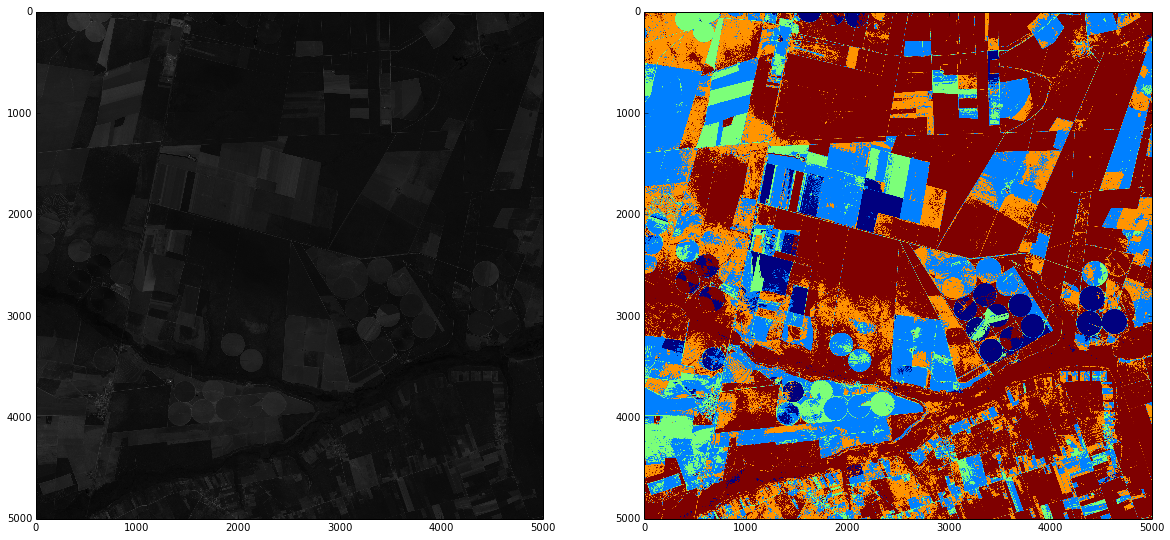

In [52]:
subplot(1,2,1)
imshow(Y, cmap=cm.gray)

subplot(1,2,2)
imshow(labels.reshape(5000, 5000))